# KNN

In [ ]:
#load dataset from google drive (as I am tired of uploading data manually every time)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('housing.csv') # adjust path accordingly
df.head()

Mounted at /content/drive


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
df.dropna(inplace=True)
from sklearn.model_selection import train_test_split


X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
train_df = X_train.join(y_train)

Waiting on final data pre-processing stuff

**General Outline of KNN steps**

1. Run k-fold cross validation & plot to find the best k hyperparameter

2. Then run a model using that k & plot decision boundary

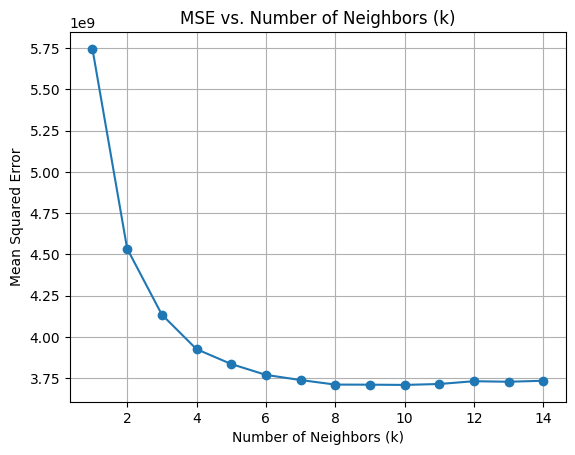

The best k is: 10 with an MSE of: 3709167220.827241


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('housing.csv')

# Handle missing values by imputing with the mean for total_bedrooms
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)

X = df.drop(columns=['median_house_value', 'ocean_proximity'])
y = df['median_house_value']

X = (X - X.mean()) / X.std()

# To store the mean squared error for each k
mse_scores_knn = []

# Varying the number of neighbors for kNN from 1 to 15
for k in range(1, 15):
    knn_model = KNeighborsRegressor(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = -cross_val_score(knn_model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mse_scores_knn.append(np.mean(scores))

plt.plot(range(1, 15), mse_scores_knn, marker='o')
plt.title('MSE vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

# Find the best k for kNN
best_k_knn = range(1, 15)[np.argmin(mse_scores_knn)]
best_mse_knn = min(mse_scores_knn)

print(f"The best k is: {best_k_knn} with an MSE of: {best_mse_knn}")


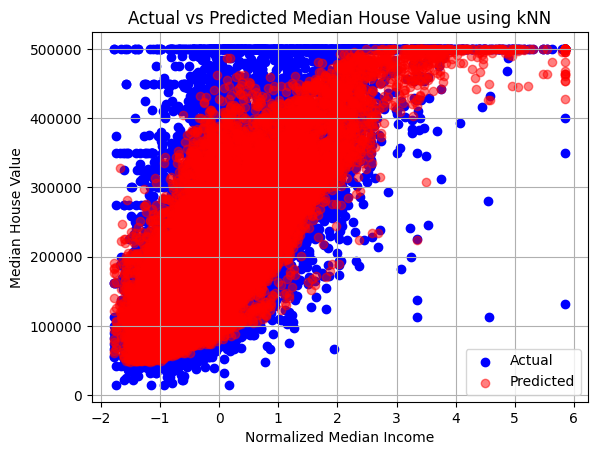

In [ ]:
knn_best = KNeighborsRegressor(n_neighbors=best_k_knn)
knn_best.fit(X, y)

y_pred = knn_best.predict(X)

plt.scatter(X['median_income'], y, color='blue', label='Actual')
plt.scatter(X['median_income'], y_pred, color='red', alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted Median House Value using kNN')
plt.xlabel('Normalized Median Income')
plt.ylabel('Median House Value')
plt.legend()
plt.grid(True)
plt.show()


R^2 calculations

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

df = pd.read_csv('housing.csv')

df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)

X_no_ocean_proximity = df.drop(columns=['median_house_value', 'ocean_proximity'])
y_no_ocean_proximity = df['median_house_value']

X_no_ocean_proximity_normalized = (X_no_ocean_proximity - X_no_ocean_proximity.mean()) / X_no_ocean_proximity.std()

knn_no_ocean_proximity = KNeighborsRegressor(n_neighbors=10)
knn_no_ocean_proximity.fit(X_no_ocean_proximity_normalized, y_no_ocean_proximity)

y_pred_no_ocean_proximity = knn_no_ocean_proximity.predict(X_no_ocean_proximity_normalized)

# Calculate R-squared for k=10 without one-hot encoding
r2_no_ocean_proximity = r2_score(y_no_ocean_proximity, y_pred_no_ocean_proximity)

print(f'R-squared for k=10 without one-hot encoding of ocean_proximity: {r2_no_ocean_proximity}')


R-squared for k=10 without one-hot encoding of ocean_proximity: 0.7769713307670736


One hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('housing.csv')

df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)

# One-hot encode the ocean_proximity feature
encoder = OneHotEncoder(sparse_output=False)
ocean_proximity_encoded = encoder.fit_transform(df[['ocean_proximity']])

# Creating a DataFrame with the one-hot encoded columns
ocean_proximity_df = pd.DataFrame(ocean_proximity_encoded, columns=encoder.get_feature_names_out(['ocean_proximity']))

# Concatenate the one-hot encoded columns with the original dataframe, excluding ocean_proximity
df_encoded = pd.concat([df.drop(columns=['ocean_proximity']), ocean_proximity_df], axis=1)

X = df_encoded.drop(columns=['median_house_value'])
y = df_encoded['median_house_value']

X = (X - X.mean()) / X.std()

KNN with the one-hot encoding for ocean proximity

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


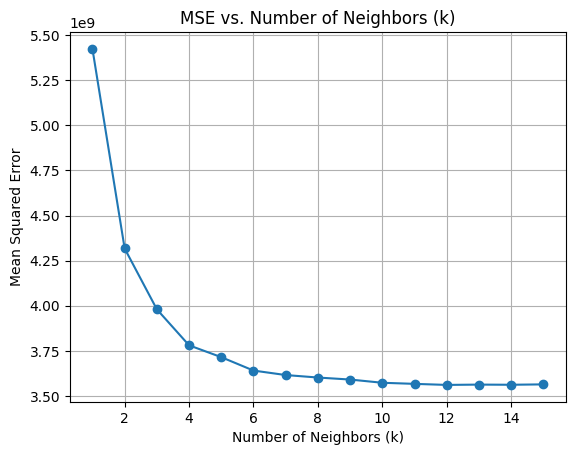

The best k is: 12 with an MSE of: 3561524474.537329


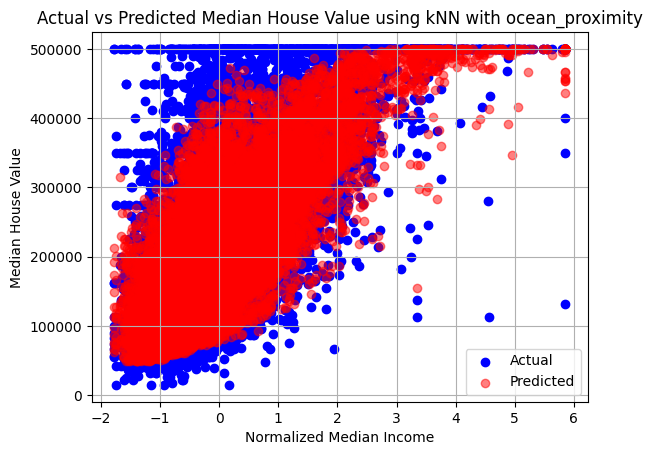

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('housing.csv')

df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)

# One-hot encode the ocean_proximity feature
encoder = OneHotEncoder(sparse=False)
ocean_proximity_encoded = encoder.fit_transform(df[['ocean_proximity']])

# Creating a DataFrame with the one-hot encoded columns
ocean_proximity_df = pd.DataFrame(ocean_proximity_encoded, columns=encoder.get_feature_names_out(['ocean_proximity']))

# Concatenate the one-hot encoded columns with the original dataframe, excluding ocean_proximity
df_encoded = pd.concat([df.drop(columns=['ocean_proximity']), ocean_proximity_df], axis=1)

X = df_encoded.drop(columns=['median_house_value'])
y = df_encoded['median_house_value']

X_normalized = (X - X.mean()) / X.std()

# To store the mean squared error for each k
mse_scores_knn = []

# Varying the number of neighbors for kNN from 1 to 15
for k in range(1, 16):
    knn_model = KNeighborsRegressor(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = -cross_val_score(knn_model, X_normalized, y, cv=kf, scoring='neg_mean_squared_error')
    mse_scores_knn.append(np.mean(scores))

plt.plot(range(1, 16), mse_scores_knn, marker='o')
plt.title('MSE vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

best_k_knn = range(1, 16)[np.argmin(mse_scores_knn)]
best_mse_knn = min(mse_scores_knn)

print(f"The best k is: {best_k_knn} with an MSE of: {best_mse_knn}")

knn_best = KNeighborsRegressor(n_neighbors=best_k_knn)
knn_best.fit(X_normalized, y)

y_pred = knn_best.predict(X_normalized)

plt.scatter(X_normalized['median_income'], y, color='blue', label='Actual')
plt.scatter(X_normalized['median_income'], y_pred, color='red', alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted Median House Value using kNN with ocean_proximity')
plt.xlabel('Normalized Median Income')
plt.ylabel('Median House Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import r2_score

knn_best = KNeighborsRegressor(n_neighbors=12)
knn_best.fit(X_normalized, y)

y_pred = knn_best.predict(X_normalized)

r2_knn = r2_score(y, y_pred)
print(f"R-squared for k = 12: {r2_knn}")



R-squared for k = 12: 0.7761338121311256
